# Init

In [1]:
%cd ..
%load_ext autoreload

import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy.signal import find_peaks
from src.plotting_functions import _update_layout
from pathlib import Path

c:\Users\kepes\Projects\segmentation


c:\Users\kepes\Projects\segmentation\src\MapData.py:164: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


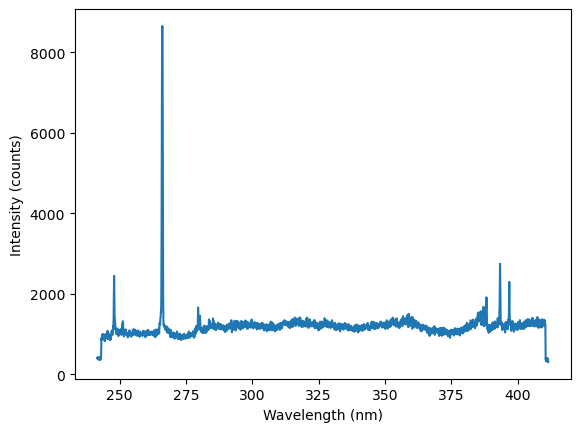

In [6]:
%autoreload 2
from src.MapData import MapData

map_data = MapData()
map_data.get_metadata()
map_data.load_wavelenths()
map_data.plot_random_spectrum(return_fig=False)

# LineFinder definition

In [106]:
%%writefile ./src/LineFinder.py
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy.signal import find_peaks
from src.plotting_functions import _update_layout
from pathlib import Path

class LineFinder():
    """_summary_
    """


    def __init__(
        self,
        spectrum:np.array,
        wvl:np.array,
        name:str,
        **kwargs
    ):
        """_summary_

        Args:
            spectrum (np.array): _description_
            wvl (np.array): _description_
            name (str): _description_
        """
        self.spectrum = spectrum.copy()
        self.wvl = wvl.copy()
        self.name = name


    def find_lines(
        self,        
        height:float=(0,1),
        prominence:float=None,
        distance:int=None,
        width:int=None,
        threshold:float=None,
        rel_height:float=None,
        wlen:int=None,
    ) -> None:
        """Wrapper around the scikit.signal find_peaks function.
        """
        self.peaks = find_peaks(
            self.spectrum,
            height=height,
            prominence=prominence,
            distance=distance,
            width=width,
            threshold=threshold,
            rel_height=rel_height,
            wlen=wlen
        )


    def plot_found_lines(
        self,
        show_cond:bool=True
    ) -> None:
        """Marks the found emission lines (their maxima) in the spectrum and frames them using the left and right boundaries found by the peak finder.

        Args:
            show_cond (bool, optional): Whether to show the updated plot. Defaults to True.
        """
        try:
            getattr(self, 'peaks')
        except AttributeError:
            print('performing line finding')
            self.find_lines()

        self.plot = go.Figure()
        self.plot = self.plot.add_trace(
            go.Scatter(
                x=np.squeeze(self.wvl),
                y=np.squeeze(self.spectrum),
                showlegend=True,
                name=self.name
            )
        )

        self.plot.add_trace(
            go.Scatter(
                x=self.wvl[self.peaks[0]],
                y=self.spectrum[self.peaks[0]],
                mode='markers',
                name='Found peaks'
            )
        )

        self.plot = _update_layout(self.plot)

        for line_ndx,emission_line_data in enumerate(zip(
            self.peaks[1]['left_bases'],
            self.peaks[1]['peak_heights'],
            self.peaks[1]['right_bases'],
        )):

            rect_color = 'rgb(255,0,0)' if line_ndx % 2 == 0 else 'rgb(255,255,0)'

            self.plot.add_shape(
                x0=self.wvl[emission_line_data[0]],
                x1=self.wvl[emission_line_data[2]],
                y0=0,
                y1=emission_line_data[1] * 1.2,
                opacity=.2,
                fillcolor=rect_color
            )

        if show_cond: self.plot.show()


    def add_spectrum_to_plot(
        self,
        spectrum:np.array,
        name:str,
        wvl:np.array=None,
        scale:bool=True,
        show_cond:bool=True
    ) -> None:
        """Add a new spectrum to the existing plot.

        Args:
            spectrum (np.array): The new spectrum to be added to the plot.
            name (str): The name to identify the new spectrum in the plot (it's label in the legend).
            wvl (np.array, optional): A wavelength vector corresponding to the new spectrum, if differs from the existing wavelengths. Defaults to None.
            scale (bool, optional): Whether to scale the new spectrum by the initial spectrum's maximum. Defaults to True.
            show_cond (bool, optional): Whether to show the updated figure. Defaults to True.
        """
        try:
            getattr(self, 'plot')
        except AttributeError:
            print('creating base plot')
            self.plot_found_lines(False)

        if wvl is None: wvl = self.wvl

        spectrum = spectrum.copy()
        if scale: spectrum *= np.max(self.spectrum)

        self.plot.add_trace(
            go.Scatter(
                x=wvl,
                y=spectrum,
                mode='lines',
                name=name
            )
        )

        if show_cond: self.plot.show()


    def find_peaks_in_reference(
        self,
        spectrum:np.array=None,
        name:str=None,
        wvl:np.array=None,
        scale:bool=True,
        show_cond:bool=True
    ) -> None:
        """Compares the emission lines found in the initial spectrum and compares to a reference spectrum. Creates a list of indices corresponding to the emission line centers in the reference spectrum.

        Args:
            spectrum (np.array): The reference spectrum where the emission line centers are to be identified.
            name (str): Name (legend label) of the reference spectrum.
            wvl (np.array, optional): A wavelength vector corresponding to the new spectrum, if differs from the existing wavelengths. Defaults to None.
            scale (bool, optional): Whether to scale the new spectrum by the initial spectrum's maximum. Defaults to True.
            show_cond (bool, optional): Whether to show the updated figure. Defaults to True.
        """
        try:
            getattr(self, 'plot')
        except AttributeError:
            print('creating base plot')
            self.plot_found_lines(False)
        try:
            getattr(self, 'peaks')
        except AttributeError:
            print('performing line finding')
            self.find_lines()

        if wvl is None: wvl = self.wvl
        if spectrum is None: 
            spectrum = self.spectrum
            name = self.name

        self.reference_peak_indices = []

        for left_ndx,right_ndx in zip(
            self.peaks[1]['left_bases'],
            self.peaks[1]['right_bases'],
        ):
            self.reference_peak_indices.append(
                spectrum[left_ndx:right_ndx].argmax() + left_ndx
            )

        spectrum = spectrum.copy()
        if scale: spectrum *= np.max(self.spectrum)

        self.plot.add_trace(
            go.Scatter(
                x=wvl,
                y=spectrum,
                mode='lines',
                name=name
            )
        )
            
        self.plot.add_trace(
            go.Scatter(
                x=wvl[self.reference_peak_indices],
                y=spectrum[self.reference_peak_indices],
                mode='markers',
                name='Spectrum  peaks'
            )
        )

        if show_cond: self.plot.show()

    @staticmethod
    def _update_layout(
        figure:go.Figure,
        x:str='Wavelength (nm)',
        y:str='Intensity (-)'
    ) -> go.Figure:
        """Updates a figures layout according to a hard-coded style. 

        Args:
            figure (go.Figure): The input figure, whose layout is to be updated.
            x (str, optional): X axis label. Defaults to 'Wavelength (nm)'.
            y (str, optional): Y axis label. Defaults to 'Intensity (-)'.

        Returns:
            go.Figure: The figure with the updated layout.
        """
        return(
            figure.update_layout(
                legend=dict(
                    x=.99,
                    y=.95,
                    yanchor="top",
                    xanchor="right"
                ),
                margin=dict(
                    t=50,
                    b=60,
                    l=60,
                    r=10
                ),
                xaxis=dict(
                    title=x,
                    linecolor='rgba(25,25,25,.4)',
                    mirror=True,
                    linewidth=2,
                    showgrid=True,
                    gridwidth=1,
                    gridcolor='rgba(77,77,77,.1)'
                ),
                yaxis=dict(
                    title=y,
                    linecolor='rgba(25,25,25,.4)',
                    mirror=True,
                    linewidth=2,
                    showgrid=True,
                    gridwidth=1,
                    gridcolor='rgba(77,77,77,.1)'
                ),
                plot_bgcolor="#FFF"
            )
        )

    @staticmethod
    def _get_potential_lines(
        wvl:float,
        line_tables:pd.DataFrame,
        line_shift_margin:float=.2,
        verbose:bool=True
    ) -> pd.DataFrame:
        """Matches a wvl value against a dataframe of emission lines (from NIST) and returns all emission lines in the vicinity.

        Args:
            wvl (float): A wavelength value.
            line_tables (pd.DataFrame): Dataframe of NIST emission lines.
            line_shift_margin (float, optional): The half width of the wavelength range where the emission lines are to be matched. Defaults to .2.
            verbose (bool, optional): Whether to print the emission lines found. Defaults to True.

        Returns:
            pd.DataFrame: The found emission lines; a subset of the line_tables input.
        """
        potential_line_cond = np.abs(
            line_tables['obs_wl_air(nm)'] - wvl
        ) <= line_shift_margin

        potential_line_count = np.sum(potential_line_cond)
        if verbose:
            print(
                f'{potential_line_count} potential lines found @ {wvl} nm'
            )

        potential_lines = line_tables.loc[
            potential_line_cond,
            # 'Ei(cm-1)',
            ['element','sp_num','obs_wl_air(nm)','intens','Aki(s^-1)','Ek(cm-1)','g_k']
        ]

        if verbose:
            print(potential_lines)

        return(potential_lines)


    def match_peaks_to_tables(
        self,        
        verbose:bool=False,
        line_shift_margin:float=.2
    ):
        """Gets the potential emission lines for each peak center found in the spectrum.

        Args:
            verbose (bool, optional): Whether to print the found emission lines. Defaults to False.
        """
        self.potential_lines = {
            x:self._get_potential_lines(
                x,
                line_tables=self.line_tables,
                line_shift_margin=line_shift_margin,
                verbose=verbose
            )
            for x
            in self.wvl[self.reference_peak_indices]
        }


    @staticmethod
    def _get_vline_hover_coords(
        input_figure:go.Figure,
        coord_count:int
    ) -> np.array:
        """Creates a vector of <coord_count> values between the lowest and highest value found in the <input_figure> across all its traces.

        Args:
            input_figure (go.Figure): An input figure with several traces.
            coord_count (int, optional): The number of values to return. Defaults to 100.
        """
        max_y = max(
            map(
                max,
                map(
                    lambda x: x['y'],
                    input_figure.data
                )
            )
        )
        min_y = min(
            map(
                min,
                map(
                    lambda x: x['y'],
                    input_figure.data
                )
            )
        )

        return(np.linspace(min_y,max_y,coord_count))
    
    @staticmethod
    def _get_hover_text(
        detected_wvl:float,
        print_data:pd.DataFrame
    ) -> str:
        """_summary_

        Args:
            detected_wvl (float): _description_
            print_data (pd.DataFrame): _description_

        Returns:
            str: _description_
        """
        if print_data is None:
            return('unknown')
        
        print_data = print_data\
            .sort_values(['intens','sp_num'])\
            .groupby(['element','sp_num'])\
            .head(1)\
            .sort_values('intens',ascending=False)

        print_header = 'line | NIST intensity | E<sub>k</sub> (cm<sup>-1</sup>) | A<sub>ki</sub> (s<sup>-1</sup>)'
        
        full_hover_text = '{:.2f} :: <br> {} <br> {}'.format(
            detected_wvl,
            print_header,
            '-'*(len(print_header) // 2)
        )

        for ndx in print_data.index:
            print_element = print_data.loc[ndx,'element']
            print_ionization = 'I'*print_data.loc[ndx,'sp_num']
            print_linecenter = print_data.loc[ndx,'obs_wl_air(nm)']
            print_intens = print_data.loc[ndx,'intens']
            print_Ek = print_data.loc[ndx,'Ek(cm-1)']
            print_Aki = print_data.loc[ndx,'Aki(s^-1)']

            hover_text = '{} {} {:.2f} nm | {} | {} | {}'.format(
                print_element,
                print_ionization,
                print_linecenter,
                print_intens,
                print_Ek,
                print_Aki
            )

            full_hover_text = f'{full_hover_text} <br> {hover_text}'

        if len(full_hover_text) == 0:
            full_hover_text = 'unknown'

        return(full_hover_text)


    def plot_potential_lines(
        self,
        coord_count:int=100,
        show_cond:bool=True
    ) -> None:
        """_summary_

        Args:
            coord_count (int, optional): _description_. Defaults to 100.
            show_cond (bool, optional): _description_. Defaults to True.

        Raises:
            AttributeError: _description_
        """
        try:
            getattr(self, 'plot')
        except AttributeError:
            print('creating base plot')
            self.plot_found_lines(False)
        try:
            getattr(self, 'peaks')
        except AttributeError:
            print('performing line finding')
            self.find_lines()
        try:
            getattr(self, 'potential_lines')
        except AttributeError:            
            raise AttributeError(
                '''peaks must be matched to reference tables first 
                via match_peaks_to_tables()'''
            )

        self.potential_lines_fig = go.Figure()

        for trace in self.plot.data:
            if trace['name'] != 'Found peaks':
                self.potential_lines_fig.add_trace(trace)

        self.potential_lines_fig = self._update_layout(self.potential_lines_fig)

        for line in self.potential_lines:
            self.potential_lines_fig.add_vline(
                line,
                opacity=.2
            )
            self.potential_lines_fig.add_trace(
                go.Scatter(
                    x=[line] * coord_count,
                    y=self._get_vline_hover_coords(
                        self.potential_lines_fig,
                        coord_count
                    ),
                    name='',
                    opacity=.0,
                    showlegend=False,
                    hovertext=self._get_hover_text(
                        detected_wvl=line,
                        print_data=self.potential_lines[line],
                    ),
                    hoverinfo='text',
                    hoverlabel=dict(
                        bgcolor='rgba(250,250,250,.5)'
                    )
                )
            )
            
        if show_cond: self.potential_lines_fig.show()


    def load_nist_tables(
        self,
        source_path:Path
    ):
        table_files = pd.DataFrame(
            source_path.glob('*.txt'),
            columns=['file']
        )
        table_files.index=map(
            lambda x: x.stem,
            source_path.glob('*.txt')
        )

        line_tables = []
        for element in table_files.index:
            line_table = pd.read_csv(
                table_files.loc[element,'file']
            )
            line_table.replace(
                r'[="\*:]', '',
                regex=True,
                inplace=True
            )
            line_table.replace(
                '',np.nan,
                inplace=True
            )
            line_table['intens'].replace(
                '[a-z]','',
                regex=True,
                inplace=True
            )
            line_table['obs_wl_air(nm)'] = list(map(
                float,
                line_table['obs_wl_air(nm)']
            ))
            line_table['intens'] = list(map(
                float,
                line_table['intens'].replace(
                    '[^0-9]','',
                    regex=True
                ).replace('',np.nan)
            ))

            line_table['Aki(s^-1)'] = list(map(
                float,
                line_table['Aki(s^-1)']
            ))
            line_table.dropna(
                subset=['Aki(s^-1)'],
                inplace=True
            )

            line_table = line_table.loc[
                (line_table['obs_wl_air(nm)'] >= self.wvl.min()) & \
                (line_table['obs_wl_air(nm)'] <= self.wvl.max()),
            ]
            line_tables.append(line_table)

        self.line_tables = pd.concat(line_tables)

        # combined_line_table = combined_line_table.loc[
        #     combined_line_table['sp_num'] <= 3,:
        # ]

Overwriting ./src/LineFinder.py


## NIST tables

In [5]:
TABLE_PATH = Path(
    'C:/Users/kepes/OneDrive - Vysoké učení technické v Brně/projects/marsData/inventory/nistTables'
)

## Lines in random spectrum

In [100]:
map_data.random_spectrum /= np.max(map_data.random_spectrum)

line_finder = LineFinder(
    spectrum=map_data.random_spectrum,
    name='random spectrum',
    wvl=map_data.wvl
)

line_finder.find_lines(
    height=(.005,1),
    threshold=None,
    distance=None,
    prominence=2.5e-2,
    # width=17,
    wlen=19,
    rel_height=1e-1,
)
line_finder.peaks
line_finder.plot_found_lines()
line_finder.load_nist_tables(TABLE_PATH)

In [103]:
line_finder.find_peaks_in_reference()
line_finder.match_peaks_to_tables(
    line_shift_margin=.1,
    verbose=True
)
line_finder.potential_lines
line_finder.plot_potential_lines()


14 potential lines found @ 247.95912170410156 nm
     element  sp_num  obs_wl_air(nm)    intens    Aki(s^-1)    Ek(cm-1)   g_k
277       Al       5      247.975000      20.0   28200000.0    836937.4   4.0
3578      Fe       2      247.914330    1200.0   12000000.0  106846.649   4.0
3580      Fe       2      247.922770    4000.0   36000000.0   78487.144   4.0
3581      Fe       2      247.929280    3100.0    1900000.0   66377.315   8.0
3582      Fe       2      247.938140    6000.0    9000000.0   82978.717  10.0
3584      Fe       1      247.948020     650.0   21000000.0   48304.643   5.0
3585      Fe       1      247.962780     129.0     706000.0   47693.239   7.0
3587      Fe       1      247.977620    7600.0  174000000.0   41018.051   5.0
3588      Fe       2      247.985180     900.0    8000000.0  103002.660   6.0
3589      Fe       2      248.015734  210000.0  155000000.0   62945.045   8.0
614       Mn       2      247.898500      20.0     750000.0    67910.56   9.0
617       Mn   

{247.95912:     element  sp_num  obs_wl_air(nm)       intens   Aki(s^-1)     Ek(cm-1)  g_k
 275      Al       2       247.52520       1500.0  46000000.0   125869.015  3.0
 277      Al       5       247.97500         20.0  28200000.0     836937.4  4.0
 278      Al       5       248.16000          5.0   2630000.0     836937.4  4.0
 180       C       1       247.85612  640000000.0  28000000.0  61981.83211  NaN
 109      Ca       3       247.02920        800.0  90000000.0    331403.20  3.0
 ..      ...     ...             ...          ...         ...          ...  ...
 396      Ti       2       247.29408          4.0   2080000.0   40425.7183  4.0
 397      Ti       2       247.41947         17.0    651000.0   40798.4333  8.0
 399      Ti       2       247.72028         14.0    790000.0   40581.6301  6.0
 400      Ti       2       247.86965         10.0    512000.0   40425.7183  4.0
 404      Ti       2       248.15000          4.0   2000000.0   44914.8733  4.0
 
 [139 rows x 7 columns],
 2